In [99]:
ls

2Autoencoder.ipynb    lens_2000_no_sc.h5        LSST_generator.py
generator_LSST.ipynb  lens_dataset_lsst_rgb.h5  VAE.ipynb
generator.py          lensenv/                  VAE_LSST.ipynb
lens_1000_no_sc.h5    lenstronomy-tutorials/
lens_10k_no_sc.h5     LSST_EUCLID.ipynb


In [100]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import TensorDataset
from tqdm import trange

import torch.nn.functional as F

Available datasets: ['delta_psi_maps', 'images_clean', 'images_rgb', 'subhalo_mass', 'subhalo_x', 'subhalo_y']
images_rgb shape: (500, 40, 40, 3)
images_clean shape: (500, 40, 40, 3)
delta_psi_maps shape: (500, 40, 40)
subhalo_mass shape: (500,)
subhalo_x shape: (500,)
subhalo_y shape: (500,)
Plotting samples: [491 481 106]


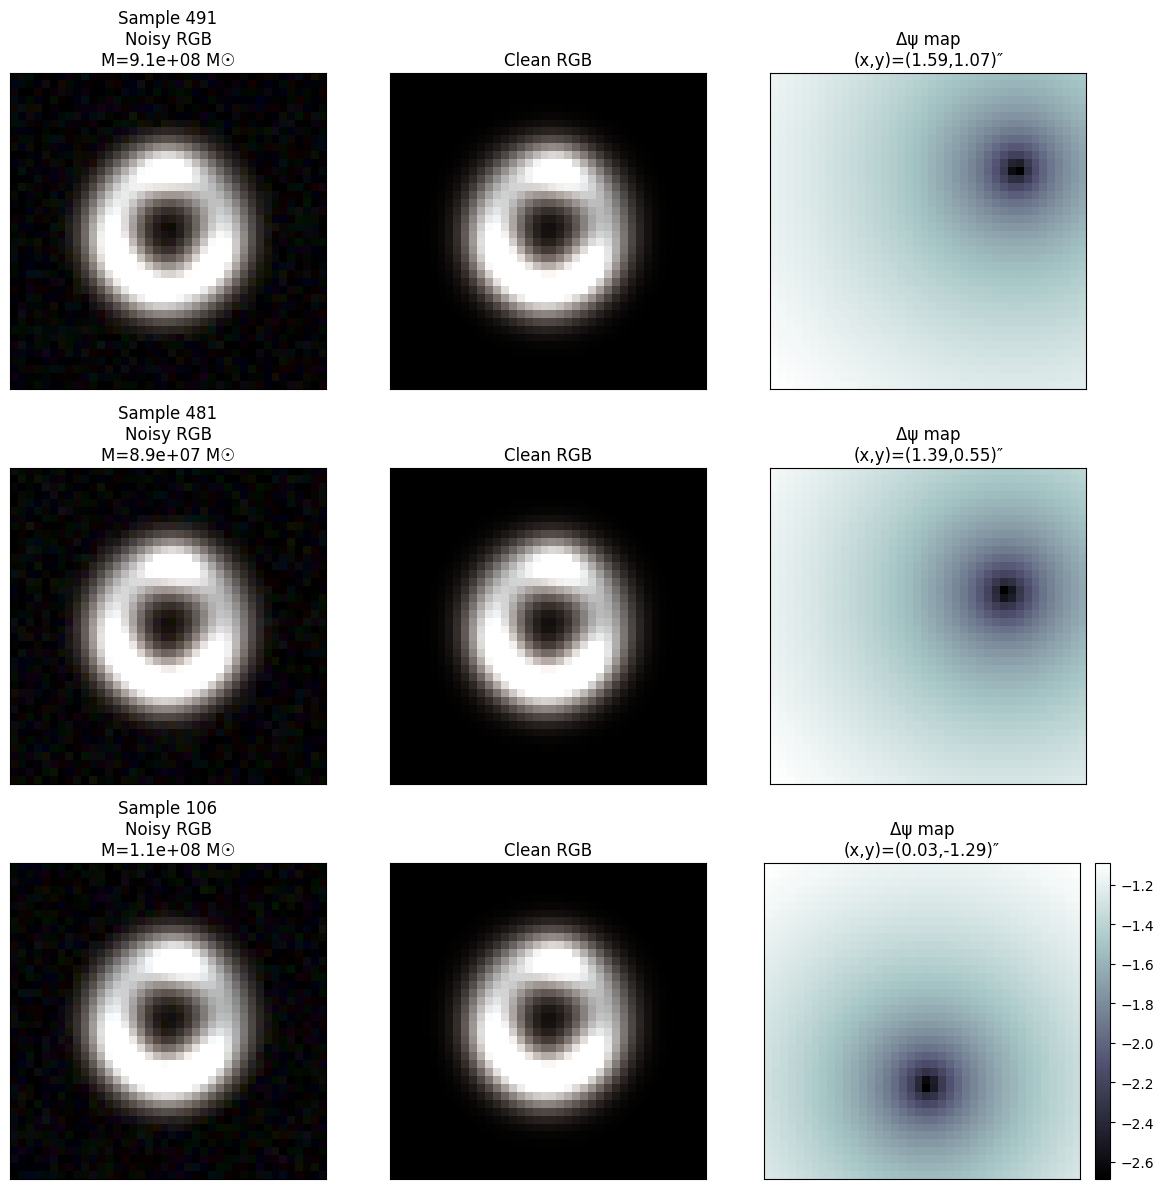

In [101]:
# Path to the new RGB HDF5 dataset
h5_path = 'lens_dataset_lsst_rgb.h5'

with h5py.File(h5_path, 'r') as f:
    print("Available datasets:", list(f.keys()))
    print("images_rgb shape:", f['images_rgb'].shape)
    print("images_clean shape:", f['images_clean'].shape)
    print("delta_psi_maps shape:", f['delta_psi_maps'].shape)
    print("subhalo_mass shape:", f['subhalo_mass'].shape)
    print("subhalo_x shape:", f['subhalo_x'].shape)
    print("subhalo_y shape:", f['subhalo_y'].shape)

    # Choose three random sample indices
    N = f['images_rgb'].shape[0]
    sample_indices = np.random.choice(N, size=3, replace=False)
    print("Plotting samples:", sample_indices)

    # Create figure with 3 rows and 3 columns
    fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for row, idx in enumerate(sample_indices):
        img_rgb     = f['images_rgb'][idx]    # shape (ny, nx, 3)
        img_clean   = f['images_clean'][idx]  # shape (ny, nx, 3)
        delta_psi   = f['delta_psi_maps'][idx]
        mass        = f['subhalo_mass'][idx]
        x_sub, y_sub = f['subhalo_x'][idx], f['subhalo_y'][idx]

        # Panel 1: RGB image with noise
        axes[row, 0].imshow(img_rgb, origin='lower')
        axes[row, 0].set_title(f"Sample {idx}\nNoisy RGB\nM={mass:.1e} M☉")

        # Panel 2: RGB image clean (no subhalo, no noise)
        axes[row, 1].imshow(img_clean, origin='lower')
        axes[row, 1].set_title("Clean RGB")

        # Panel 3: Δψ map
        im2 = axes[row, 2].imshow(delta_psi, origin='lower', cmap='bone')
        axes[row, 2].set_title(f"Δψ map\n(x,y)=({x_sub:.2f},{y_sub:.2f})″")

        # Colorbar only for Δψ on the last row
        if row == 2:
            fig.colorbar(im2, ax=axes[row, 2], fraction=0.046, pad=0.04)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


In [102]:
# 1) Load the data from the HDF5 file
with h5py.File(h5_path, 'r') as f:
    X_noisy  = f['images_rgb'][:]    # (N, H, W, 3)
    Y_smooth = f['images_clean'][:]   # (N, H, W, 3)
    Y_delta  = f['delta_psi_maps'][:]  # (N, H, W, 3)
    sub_mass = f['subhalo_mass'][:]  # (N,)
    sub_x    = f['subhalo_x'][:]     # (N,)
    sub_y    = f['subhalo_y'][:]     # (N,)

In [103]:
X_noisy.shape

(500, 40, 40, 3)

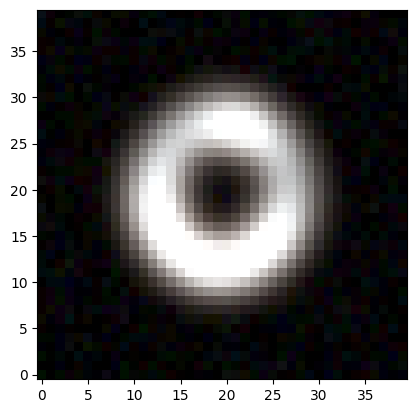

In [104]:
plt.imshow(X_noisy[0], origin='lower')

### Step 2: Pre-processing

We first remove any invalid entries (NaN or ±Inf), then wrap the arrays into PyTorch tensors and add the channel dimension.




In [105]:
# 2) Clean the data (mismo que antes)
X_noisy = np.nan_to_num(X_noisy, nan=0.0, posinf=None, neginf=None)
Y_smooth = np.nan_to_num(Y_smooth, nan=0.0, posinf=None, neginf=None)
Y_delta  = np.nan_to_num(Y_delta,  nan=0.0, posinf=None, neginf=None)
sub_mass = np.nan_to_num(sub_mass, nan=0.0, posinf=None, neginf=None)
sub_x    = np.nan_to_num(sub_x,    nan=0.0, posinf=None, neginf=None)
sub_y    = np.nan_to_num(sub_y,    nan=0.0, posinf=None, neginf=None)

# 3) Convertir a tensores en formato channel-first
# X_noisy: (N, H, W, 3) -> (N, 3, H, W)
X  = torch.from_numpy(X_noisy).permute(0, 3, 1, 2).float()

# Y_smooth: si también es RGB (N, H, W, 3) -> (N, 3, H, W)
Y1 = torch.from_numpy(Y_smooth).permute(0, 3, 1, 2).float()

# Y_delta: 1 canal (N, H, W) -> (N, 1, H, W)
Y2 = torch.from_numpy(Y_delta).float().unsqueeze(1)


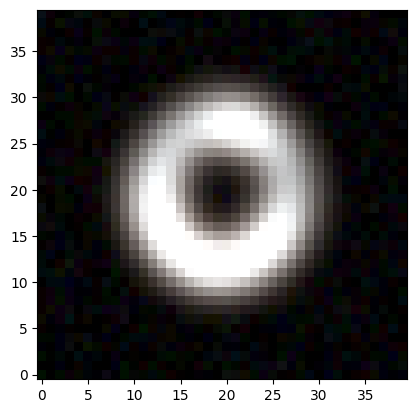

In [106]:
plt.imshow(X[0].permute(1, 2, 0).numpy(), origin='lower')

In [107]:
#Split the data into training, validation, and test sets
# 1) Índices para cada subconjunto
idx = np.arange(X.shape[0])

# 10% para test
idx_rest, idx_test = train_test_split(idx, test_size=0.10, random_state=42)

# De lo que queda (90%), separar 20% para validación → equivale a 2/9 ≈ 22.22%
idx_train, idx_val = train_test_split(idx_rest, test_size=2/9, random_state=42)

# 2) Split de imágenes
X_train, X_val, X_test   = X[idx_train],  X[idx_val],  X[idx_test]
Y1_train, Y1_val, Y1_test = Y1[idx_train], Y1[idx_val], Y1[idx_test]
Y2_train, Y2_val, Y2_test = Y2[idx_train], Y2[idx_val], Y2[idx_test]

# 3) Split de masa y coordenadas
sub_mass_train, sub_mass_val, sub_mass_test = sub_mass[idx_train], sub_mass[idx_val], sub_mass[idx_test]
sub_x_train, sub_x_val, sub_x_test = sub_x[idx_train], sub_x[idx_val], sub_x[idx_test]
sub_y_train, sub_y_val, sub_y_test = sub_y[idx_train], sub_y[idx_val], sub_y[idx_test]

In [108]:
#Visualización de los datos
def describe_tensor(t, name):
    print(f"--- {name} ---")
    print("Shape:", t.shape)
    print("Min:", t.min().item())
    print("Max:", t.max().item())
    print("Mean:", t.mean().item())
    print("Std:", t.std().item())
    print("Median:", t.median().item())
    print("Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]:", np.percentile(t.cpu().numpy().flatten(), [0.1, 1, 25, 50, 75, 99, 99.9]))
    print()

describe_tensor(X_train, "X_train (Noisy RGB)")
describe_tensor(Y1_train, "Y1_train (Clean RGB)")
describe_tensor(Y2_train, "Y2_train (Δψ)")


--- X_train (Noisy RGB) ---
Shape: torch.Size([350, 3, 40, 40])
Min: 0.0
Max: 1.0
Mean: 0.19150635600090027
Std: 0.3040001094341278
Median: 0.04333358630537987
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [0.         0.         0.         0.0433336  0.21741959 1.
 1.        ]

--- Y1_train (Clean RGB) ---
Shape: torch.Size([350, 3, 40, 40])
Min: 1.5442640943774677e-08
Max: 1.0
Mean: 0.17884907126426697
Std: 0.3086007237434387
Median: 0.004070228431373835
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [1.79596533e-08 7.60655809e-08 1.03040056e-04 4.07052878e-03
 2.14692745e-01 1.00000000e+00 1.00000000e+00]

--- Y2_train (Δψ) ---
Shape: torch.Size([350, 1, 40, 40])
Min: -2.977926015853882
Max: -0.5498024821281433
Mean: -1.4742683172225952
Std: 0.36475083231925964
Median: -1.477462649345398
Percentiles [0.1, 1, 25, 50, 75, 99, 99.9]: [-2.68972808 -2.36647569 -1.72728255 -1.47746229 -1.19691649 -0.76747744
 -0.67431791]



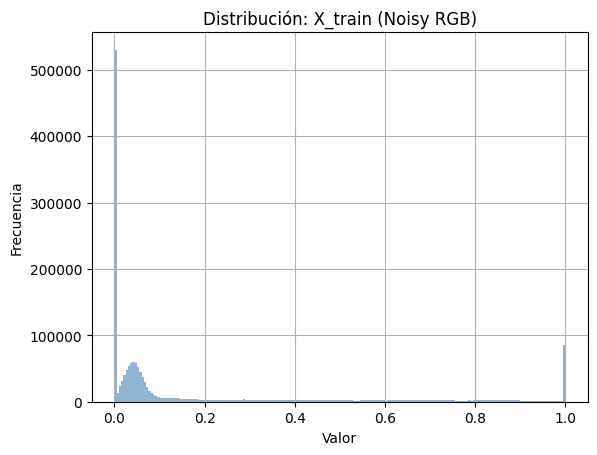

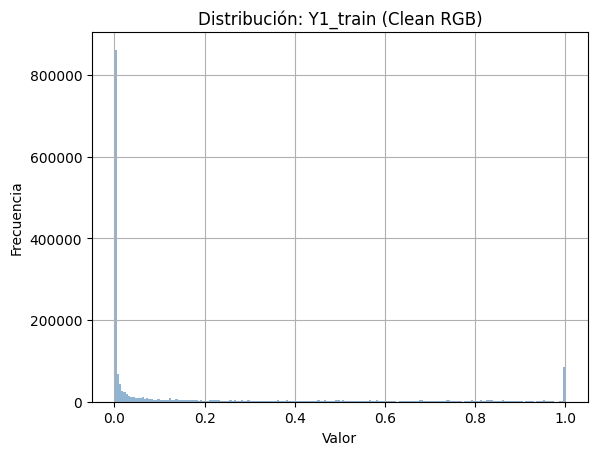

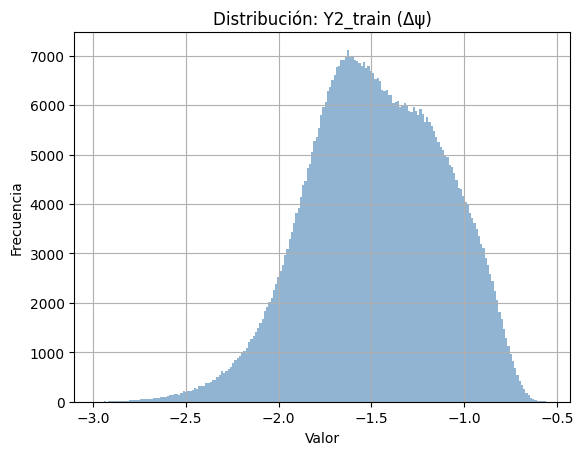

In [109]:
#Histograma de las variables
def plot_histogram(tensor, title, bins=200):
    t_np = tensor.cpu().numpy().flatten()
    plt.hist(t_np, bins=bins, alpha=0.6, color='steelblue')
    plt.title(title)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

plot_histogram(X_train, "Distribución: X_train (Noisy RGB)")
plot_histogram(Y1_train, "Distribución: Y1_train (Clean RGB)")
plot_histogram(Y2_train, "Distribución: Y2_train (Δψ)")


In [110]:
# --- Asegurar conversión a tensores ---
sub_mass_train = torch.tensor(sub_mass_train).float()
sub_mass_val   = torch.tensor(sub_mass_val).float()
sub_mass_test  = torch.tensor(sub_mass_test).float()

sub_x_train = torch.tensor(sub_x_train).float()
sub_x_val   = torch.tensor(sub_x_val).float()
sub_x_test  = torch.tensor(sub_x_test).float()

sub_y_train = torch.tensor(sub_y_train).float()
sub_y_val   = torch.tensor(sub_y_val).float()
sub_y_test  = torch.tensor(sub_y_test).float()

# --- Agrupar y normalizar ---
mxy_train = torch.stack([sub_mass_train, sub_x_train, sub_y_train], dim=1)
mxy_val   = torch.stack([sub_mass_val,   sub_x_val,   sub_y_val],   dim=1)
mxy_test  = torch.stack([sub_mass_test,  sub_x_test,  sub_y_test],  dim=1)

mean_mxy = mxy_train.mean(dim=0)
std_mxy  = mxy_train.std(dim=0)

mxy_train = (mxy_train - mean_mxy) / std_mxy
mxy_val   = (mxy_val   - mean_mxy) / std_mxy
mxy_test  = (mxy_test  - mean_mxy) / std_mxy


In [111]:
# ✅ Estadísticas que sí necesitas guardar:
# 1. Para desnormalizar Y2 (Δψ map):

# Como estás usando z-score:
mean_Y2 = Y2_train.mean().item()
std_Y2 = Y2_train.std().item()

# 2. Para desnormalizar mxy (masa, x, y):
# mean_mxy = mxy_train.mean(dim=0)  # tensor([mean_mass, mean_x, mean_y])
# std_mxy = mxy_train.std(dim=0)    # tensor([std_mass, std_x, std_y])

norm_stats = {
    "mean_Y2": mean_Y2,
    "std_Y2": std_Y2,
    "mean_mass": mean_mxy[0].item(),
    "std_mass":  std_mxy[0].item(),
    "mean_x":    mean_mxy[1].item(),
    "std_x":     std_mxy[1].item(),
    "mean_y":    mean_mxy[2].item(),
    "std_y":     std_mxy[2].item()
}


### Normalization

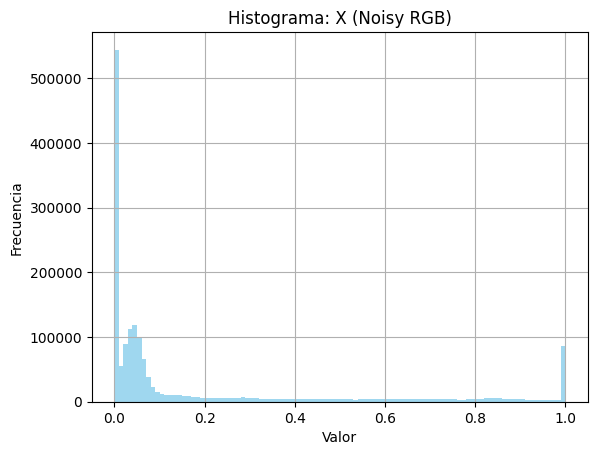

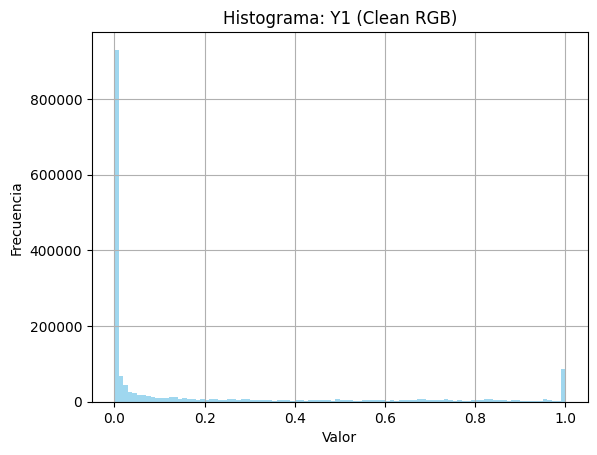

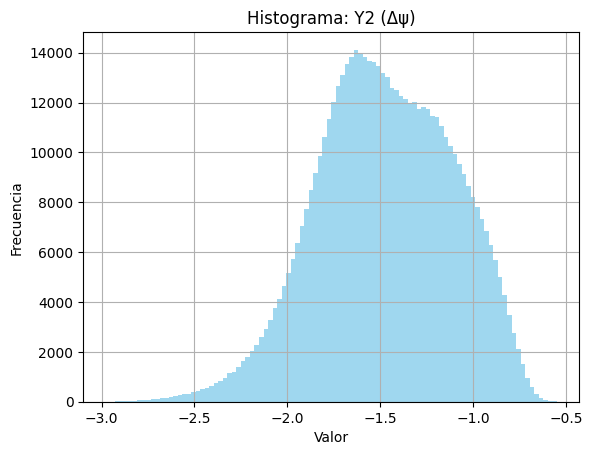

In [112]:
def plot_histogram(tensor, name):
    flat = tensor.detach().cpu().numpy().flatten()
    plt.hist(flat, bins=100, color='skyblue', alpha=0.8)
    plt.title(f"Histograma: {name}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

plot_histogram(X_train, "X (Noisy RGB)")
plot_histogram(Y1_train, "Y1 (Clean RGB)")
plot_histogram(Y2_train, "Y2 (Δψ)")


In [113]:
# #Datasats for training, witg shape (N, 3)
# mxy_train = torch.tensor(np.array([sub_mass_train, sub_x_train, sub_y_train])).float().T  # (N, 3)
# mxy_val   = torch.tensor(np.array([sub_mass_val, sub_x_val, sub_y_val])).float().T
# mxy_test  = torch.tensor(np.array([sub_mass_test, sub_x_test, sub_y_test])).float().T   

### 📦 7) Dataset and DataLoader

This section prepares the datasets and data loaders used during training, validation, and testing.

---

#### 🔹 1) Create TensorDatasets

We package the input and target tensors into `TensorDataset` objects. This allows us to efficiently iterate through the data during training and evaluation.

```python
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val, mxy_val)


In [114]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch = 64
on_cuda = torch.cuda.is_available()

# 1) Datasets
train_ds = TensorDataset(X_train, Y1_train, Y2_train, mxy_train)
val_ds   = TensorDataset(X_val,   Y1_val,   Y2_val,   mxy_val)
test_ds  = TensorDataset(X_test,  Y1_test,  Y2_test,  mxy_test)

# 2) DataLoaders
common_kwargs = dict(
    batch_size=batch,
    num_workers=4,
    pin_memory=on_cuda,
    persistent_workers=True
)

train_loader = DataLoader(
    train_ds,
    shuffle=True,
    drop_last=True,
    **common_kwargs
)

val_loader = DataLoader(
    val_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)

test_loader = DataLoader(
    test_ds,
    shuffle=False,
    drop_last=False,
    **common_kwargs
)


In [115]:
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_ds, shuffle=True, generator=g, drop_last=True, **common_kwargs)

In [116]:
# Device
# 1) Detectar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


🧠 DualVAE: Variational Autoencoder with Physical Regression

This model is a **Variational Autoencoder (VAE)** designed to process gravitational lensing data. It performs:

- **Dual reconstruction**:
  - A smooth background light source.
  - A lensing potential perturbation map (ΔΨ).
- **Regression of physical parameters**:
  - Subhalo **mass**, **x-position**, and **y-position**.

---

#### 🔹 Encoder

The encoder consists of **3 convolutional layers** with:
- 3×3 kernel, stride 2, padding 1 (downsampling by 8× total),
- ReLU activations,
- Dropout for regularization (`p=0.3`).

These layers transform the input image into a feature map, which is then flattened and projected into the latent space using two linear layers:
- `fc_mu` → mean vector `μ` (for latent variable)
- `fc_logvar` → log variance `logσ²`

---

#### 🔹 Latent Space & Sampling

To enable backpropagation through stochastic sampling, the model uses the **reparameterization trick**:

```python
z = mu + eps * std

self.fc_regs = nn.Sequential(
    nn.Linear(z_dim, z_dim // 2),
    nn.Tanh(),
    nn.Dropout(0.1),
    nn.Linear(z_dim // 2, 3)
)


In [117]:
# VAE Model (RGB smooth + 1ch delta) para H=W=40
class DualVAE(nn.Module):
    def __init__(self, in_ch=3, base_ch=16, z_dim=128, H=40, W=40):
        super().__init__()
        # ——— Encoder (3 convs stride=2) → (H/8, W/8) = (5,5) si H=W=40
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch,     base_ch,   3, 2, 1), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv2d(base_ch,   base_ch*2, 3, 2, 1), nn.ReLU(), nn.Dropout(0.1),
            nn.Conv2d(base_ch*2, base_ch*4, 3, 2, 1), nn.ReLU(), nn.Dropout(0.1),
        )

        # Tamaños tras las 3 convs (para 40→20→10→5)
        def conv_out(sz): return (sz + 2*1 - 3)//2 + 1
        H1, W1 = conv_out(H),    conv_out(W)   # 20
        H2, W2 = conv_out(H1),   conv_out(W1)  # 10
        H3, W3 = conv_out(H2),   conv_out(W2)  # 5

        self._C3 = 4 * base_ch
        self._H3 = H3
        self._W3 = W3
        feat_dim = self._C3 * H3 * W3

        # ——— VAE stats
        self.fc_mu     = nn.Linear(feat_dim, z_dim)
        self.fc_logvar = nn.Linear(feat_dim, z_dim)

        # ——— z → feature map
        self.fc_dec = nn.Linear(z_dim, feat_dim)

        # ——— Decoders: usa opad=1 en TODAS las deconvs (5→10→20→40)
        # Smooth (3 canales)
        self.decoder_s = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),                       # (N, 4C, 5, 5)
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1),# 5→10
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1),# 10→20
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(base_ch,     3,            3, 2, 1, output_padding=1) # 20→40
        )
        # Δψ (1 canal)
        self.decoder_d = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (self._C3, self._H3, self._W3)),
            nn.ConvTranspose2d(self._C3,   self._C3//2, 3, 2, 1, output_padding=1), # 5→10
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(self._C3//2, base_ch,      3, 2, 1, output_padding=1),# 10→20
            nn.ReLU(), nn.Dropout(0.1),
            nn.ConvTranspose2d(base_ch,     1,            3, 2, 1, output_padding=1) # 20→40
        )

        # ——— Cabezal de regresión (m, x, y) desde μ
        self.fc_regs = nn.Sequential(
            nn.Linear(z_dim, z_dim//2),
            nn.Tanh(), nn.Dropout(0.1),
            nn.Linear(z_dim//2, 3)
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        s = self.decoder_s(h)  # (N, 3, 40, 40)
        d = self.decoder_d(h)  # (N, 1, 40, 40)
        return s, d

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        s, d = self.decode(z)
        mxy_pred = self.fc_regs(mu)  # (N, 3)
        return s, d, mu, logvar, mxy_pred


In [118]:
model = DualVAE(in_ch=3, base_ch=20, z_dim=256, H=40, W=40).to(device)


In [119]:
# 3.3) Optimizer (puede quedarse igual)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,  # learning rate
    weight_decay=1e-4
)

In [120]:
# Loss function for the VAE and regression (adapted for RGB input)
def combined_loss(s_pred, s_true,
                  d_pred, d_true,
                  mu, logvar,
                  mxy_pred, mxy_true,
                  alpha=1.0, beta=1e-3, gamma=1.0):
    """
    Combined loss for multitask VAE:
    - Reconstruction loss for smooth image and Δψ map
    - KL divergence for latent space regularization
    - Regression loss for mass and position (m, x, y)

    Args:
        s_pred, s_true: Predicted and ground truth smooth images  (B, C, H, W)
        d_pred, d_true: Predicted and ground truth Δψ images      (B, 1, H, W)
        mu, logvar: Mean and log-variance from encoder
        mxy_pred, mxy_true: Predicted and ground truth (m, x, y)  (B, 3)
        alpha: weight for Δψ reconstruction loss
        beta:  weight for KL divergence
        gamma: weight for regression loss
    """
    # Reconstruction loss (smooth + alpha*Δψ)
    recon = F.mse_loss(s_pred, s_true) + alpha * F.mse_loss(d_pred, d_true)

    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl /= s_pred.size(0)

    vae_l = recon + beta * kl

    # Regression loss for (m, x, y)
    reg_l = F.mse_loss(mxy_pred, mxy_true)

    return vae_l + gamma * reg_l


In [121]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler(enabled=torch.cuda.is_available())

# def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0):
#     model.train()
#     running_loss = 0.0
#     for x, y_s, y_d, mxy in loader:
#         # non_blocking aprovecha pin_memory=True
#         x   = x.to(device, non_blocking=True)
#         y_s = y_s.to(device, non_blocking=True)
#         y_d = y_d.to(device, non_blocking=True)
#         mxy = mxy.to(device, non_blocking=True)

#         optimizer.zero_grad(set_to_none=True)

#         # AMP opcional (acelera en GPU, iguala en CPU)
#         with autocast(enabled=torch.cuda.is_available()):
#             p_s, p_d, mu, logvar, mxy_pred = model(x)
#             loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
#                                  alpha, beta, gamma)

#         scaler.scale(loss).backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         scaler.step(optimizer)
#         scaler.update()

#         running_loss += loss.item() * x.size(0)

#     return running_loss / len(loader.dataset)

#versión 2 de train_epoch
def train_epoch(loader, optimizer, alpha=1.0, beta=1e-3, gamma=1.0, log_batches=2):
    model.train()
    running_loss = 0.0

    for i, (x, y_s, y_d, mxy) in enumerate(loader):
        x   = x.to(device, non_blocking=True)
        y_s = y_s.to(device, non_blocking=True)
        y_d = y_d.to(device, non_blocking=True)
        mxy = mxy.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=torch.cuda.is_available()):
            p_s, p_d, mu, logvar, mxy_pred = model(x)

            # Separar componentes
            recon_s = F.mse_loss(p_s, y_s)
            recon_d = F.mse_loss(p_d, y_d)
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
            reg = F.mse_loss(mxy_pred, mxy)

            loss = recon_s + alpha * recon_d + beta * kl + gamma * reg

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)

        # Mostrar las primeras batches
        if i < log_batches:
            print(f"[Batch {i}] Loss: {loss.item():.4f} | Recon_s: {recon_s.item():.4f} | "
                  f"Recon_d: {recon_d.item():.4f} | KL: {kl.item():.4f} | Reg: {reg.item():.4f}")

    return running_loss / len(loader.dataset)



def eval_epoch(loader, alpha=1.0, beta=1e-3, gamma=1.0):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y_s, y_d, mxy in loader:
            x   = x.to(device, non_blocking=True)
            y_s = y_s.to(device, non_blocking=True)
            y_d = y_d.to(device, non_blocking=True)
            mxy = mxy.to(device, non_blocking=True)

            with autocast(enabled=torch.cuda.is_available()):
                p_s, p_d, mu, logvar, mxy_pred = model(x)
                loss = combined_loss(p_s, y_s, p_d, y_d, mu, logvar, mxy_pred, mxy,
                                     alpha, beta, gamma)

            running_loss += loss.item() * x.size(0)

    return running_loss / len(loader.dataset)


In [122]:
# Diagnóstico previo al entrenamiento
model.eval()
with torch.no_grad():
    x, y_s, y_d, mxy = next(iter(train_loader))
    x = x.to(device)
    y_s, y_d = y_s.to(device), y_d.to(device)

    s_pred, d_pred, *_ = model(x)

    print(f"s_pred: min={s_pred.min().item():.4f}, max={s_pred.max().item():.4f}")
    print(f"d_pred: min={d_pred.min().item():.4f}, max={d_pred.max().item():.4f}")
    print(f"y_s:    min={y_s.min().item():.4f}, max={y_s.max().item():.4f}")
    print(f"y_d:    min={y_d.min().item():.4f}, max={y_d.max().item():.4f}")


s_pred: min=-0.2525, max=0.2422
d_pred: min=-0.2313, max=0.1850
y_s:    min=0.0000, max=1.0000
y_d:    min=-2.9779, max=-0.6064


In [123]:
from tqdm import trange

# Training loop
num_epochs = 100
alpha = 2.0    # más peso a Δψ
beta  = 1e-4   # menor KL para evitar colapso latente
gamma = 1.0    # regression igual

train_losses = []
val_losses   = []

# barra externa por época
outer_bar = trange(1, num_epochs+1, desc="Epoch", ncols=110, colour="#0cfff3")

for epoch in outer_bar:
    train_loss = train_epoch(train_loader, optimizer, alpha, beta, gamma)
    val_loss   = eval_epoch(val_loader, alpha, beta, gamma)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    outer_bar.set_postfix(train=f"{train_loss:.4f}", val=f"{val_loss:.4f}")


Epoch:   0%|                                                                          | 0/100 [00:00<?, ?it/s]

[Batch 0] Loss: 5.1667 | Recon_s: 0.1424 | Recon_d: 2.0020 | KL: 0.2451 | Reg: 1.0203
[Batch 1] Loss: 5.7660 | Recon_s: 0.1425 | Recon_d: 2.2848 | KL: 0.2462 | Reg: 1.0540


Epoch:   3%|█▏                                      | 3/100 [00:00<00:16,  5.97it/s, train=4.1842, val=4.4988]

[Batch 0] Loss: 5.2419 | Recon_s: 0.1389 | Recon_d: 2.0117 | KL: 0.0067 | Reg: 1.0795
[Batch 1] Loss: 4.8200 | Recon_s: 0.1377 | Recon_d: 1.8094 | KL: 0.0095 | Reg: 1.0636
[Batch 0] Loss: 4.5140 | Recon_s: 0.1340 | Recon_d: 1.6475 | KL: 0.0042 | Reg: 1.0850
[Batch 1] Loss: 4.6675 | Recon_s: 0.1333 | Recon_d: 1.7481 | KL: 0.0031 | Reg: 1.0380


Epoch:   4%|█▌                                      | 4/100 [00:00<00:16,  5.98it/s, train=3.9231, val=4.2270]

[Batch 0] Loss: 4.3970 | Recon_s: 0.1302 | Recon_d: 1.6491 | KL: 0.0038 | Reg: 0.9687
[Batch 1] Loss: 4.1422 | Recon_s: 0.1292 | Recon_d: 1.4999 | KL: 0.0036 | Reg: 1.0131
[Batch 0] Loss: 3.8627 | Recon_s: 0.1236 | Recon_d: 1.3220 | KL: 0.0014 | Reg: 1.0950
[Batch 1] Loss: 4.1241 | Recon_s: 0.1221 | Recon_d: 1.5448 | KL: 0.0030 | Reg: 0.9125


Epoch:   6%|██▍                                     | 6/100 [00:01<00:14,  6.60it/s, train=3.5081, val=3.7820]

[Batch 0] Loss: 3.9491 | Recon_s: 0.1175 | Recon_d: 1.4074 | KL: 0.0015 | Reg: 1.0168
[Batch 1] Loss: 3.9645 | Recon_s: 0.1167 | Recon_d: 1.4053 | KL: 0.0016 | Reg: 1.0372
[Batch 0] Loss: 3.8838 | Recon_s: 0.1153 | Recon_d: 1.4094 | KL: 0.0018 | Reg: 0.9496
[Batch 1] Loss: 3.3903 | Recon_s: 0.1151 | Recon_d: 1.1361 | KL: 0.0025 | Reg: 1.0029


Epoch:   8%|███▏                                    | 8/100 [00:01<00:14,  6.42it/s, train=3.1791, val=3.4440]

[Batch 0] Loss: 3.3623 | Recon_s: 0.1151 | Recon_d: 1.1119 | KL: 0.0026 | Reg: 1.0235
[Batch 1] Loss: 3.5278 | Recon_s: 0.1151 | Recon_d: 1.1526 | KL: 0.0024 | Reg: 1.1075
[Batch 0] Loss: 3.2492 | Recon_s: 0.1156 | Recon_d: 1.0536 | KL: -0.0008 | Reg: 1.0264
[Batch 1] Loss: 3.4203 | Recon_s: 0.1158 | Recon_d: 1.0572 | KL: -0.0016 | Reg: 1.1901


Epoch:  10%|███▉                                   | 10/100 [00:01<00:14,  6.39it/s, train=2.8941, val=3.1398]

[Batch 0] Loss: 3.1658 | Recon_s: 0.1167 | Recon_d: 0.9906 | KL: -0.0017 | Reg: 1.0679
[Batch 1] Loss: 3.3470 | Recon_s: 0.1169 | Recon_d: 1.0840 | KL: 0.0002 | Reg: 1.0622
[Batch 0] Loss: 2.8369 | Recon_s: 0.1171 | Recon_d: 0.8335 | KL: 0.0024 | Reg: 1.0528
[Batch 1] Loss: 3.2050 | Recon_s: 0.1170 | Recon_d: 1.0576 | KL: 0.0035 | Reg: 0.9728


Epoch:  13%|█████                                  | 13/100 [00:02<00:11,  7.67it/s, train=2.5292, val=2.7394]

[Batch 0] Loss: 2.9800 | Recon_s: 0.1167 | Recon_d: 0.8665 | KL: 0.0066 | Reg: 1.1303
[Batch 1] Loss: 2.8074 | Recon_s: 0.1167 | Recon_d: 0.8731 | KL: 0.0109 | Reg: 0.9445
[Batch 0] Loss: 2.9913 | Recon_s: 0.1169 | Recon_d: 0.8660 | KL: 0.0079 | Reg: 1.1424
[Batch 1] Loss: 2.8759 | Recon_s: 0.1170 | Recon_d: 0.8685 | KL: 0.0067 | Reg: 1.0219


Epoch:  15%|█████▊                                 | 15/100 [00:02<00:10,  8.06it/s, train=2.3187, val=2.5174]

[Batch 0] Loss: 2.6211 | Recon_s: 0.1166 | Recon_d: 0.7860 | KL: 0.0112 | Reg: 0.9325
[Batch 1] Loss: 2.7374 | Recon_s: 0.1165 | Recon_d: 0.7161 | KL: 0.0085 | Reg: 1.1886
[Batch 0] Loss: 2.4204 | Recon_s: 0.1160 | Recon_d: 0.6596 | KL: 0.0064 | Reg: 0.9852
[Batch 1] Loss: 2.6299 | Recon_s: 0.1158 | Recon_d: 0.7785 | KL: 0.0082 | Reg: 0.9571


Epoch:  16%|██████▏                                | 16/100 [00:02<00:10,  7.96it/s, train=2.2300, val=2.4202]

[Batch 0] Loss: 2.6158 | Recon_s: 0.1153 | Recon_d: 0.7169 | KL: 0.0080 | Reg: 1.0668
[Batch 1] Loss: 2.4313 | Recon_s: 0.1151 | Recon_d: 0.5995 | KL: 0.0058 | Reg: 1.1172
[Batch 0] Loss: 2.4339 | Recon_s: 0.1145 | Recon_d: 0.6656 | KL: 0.0002 | Reg: 0.9883
[Batch 1] Loss: 2.2670 | Recon_s: 0.1144 | Recon_d: 0.5698 | KL: 0.0005 | Reg: 1.0130


Epoch:  19%|███████▍                               | 19/100 [00:02<00:09,  8.38it/s, train=1.9885, val=2.1705]

[Batch 0] Loss: 2.2181 | Recon_s: 0.1140 | Recon_d: 0.5710 | KL: 0.0011 | Reg: 0.9620
[Batch 1] Loss: 2.3047 | Recon_s: 0.1140 | Recon_d: 0.5869 | KL: 0.0007 | Reg: 1.0171
[Batch 0] Loss: 2.4060 | Recon_s: 0.1139 | Recon_d: 0.6118 | KL: -0.0008 | Reg: 1.0685
[Batch 1] Loss: 2.2935 | Recon_s: 0.1140 | Recon_d: 0.5890 | KL: -0.0006 | Reg: 1.0015


Epoch:  20%|███████▊                               | 20/100 [00:02<00:09,  8.10it/s, train=1.9219, val=2.1024]

[Batch 0] Loss: 1.9714 | Recon_s: 0.1135 | Recon_d: 0.4636 | KL: 0.0004 | Reg: 0.9308
[Batch 1] Loss: 2.1462 | Recon_s: 0.1132 | Recon_d: 0.5289 | KL: 0.0004 | Reg: 0.9752
[Batch 0] Loss: 2.1952 | Recon_s: 0.1130 | Recon_d: 0.5169 | KL: -0.0001 | Reg: 1.0484
[Batch 1] Loss: 2.2342 | Recon_s: 0.1131 | Recon_d: 0.5820 | KL: -0.0002 | Reg: 0.9570


Epoch:  22%|████████▌                              | 22/100 [00:03<00:10,  7.49it/s, train=1.8177, val=1.9797]

[Batch 0] Loss: 2.1541 | Recon_s: 0.1129 | Recon_d: 0.5397 | KL: -0.0000 | Reg: 0.9619
[Batch 1] Loss: 1.9532 | Recon_s: 0.1128 | Recon_d: 0.4335 | KL: 0.0001 | Reg: 0.9734
[Batch 0] Loss: 2.0588 | Recon_s: 0.1121 | Recon_d: 0.4520 | KL: 0.0001 | Reg: 1.0428
[Batch 1] Loss: 2.0097 | Recon_s: 0.1119 | Recon_d: 0.4348 | KL: -0.0000 | Reg: 1.0283


Epoch:  24%|█████████▎                             | 24/100 [00:03<00:10,  7.01it/s, train=1.7291, val=1.8816]

[Batch 0] Loss: 1.9994 | Recon_s: 0.1118 | Recon_d: 0.4540 | KL: -0.0001 | Reg: 0.9796
[Batch 1] Loss: 1.8931 | Recon_s: 0.1119 | Recon_d: 0.4003 | KL: 0.0001 | Reg: 0.9806
[Batch 0] Loss: 1.7335 | Recon_s: 0.1113 | Recon_d: 0.3622 | KL: 0.0000 | Reg: 0.8978
[Batch 1] Loss: 1.7706 | Recon_s: 0.1110 | Recon_d: 0.3536 | KL: -0.0001 | Reg: 0.9524


Epoch:  26%|██████████▏                            | 26/100 [00:03<00:12,  5.98it/s, train=1.6342, val=1.8017]

[Batch 0] Loss: 1.6817 | Recon_s: 0.1106 | Recon_d: 0.3367 | KL: -0.0000 | Reg: 0.8976
[Batch 1] Loss: 1.7453 | Recon_s: 0.1108 | Recon_d: 0.3172 | KL: 0.0000 | Reg: 1.0000
[Batch 0] Loss: 1.8659 | Recon_s: 0.1107 | Recon_d: 0.3698 | KL: 0.0000 | Reg: 1.0156
[Batch 1] Loss: 1.7690 | Recon_s: 0.1107 | Recon_d: 0.3188 | KL: -0.0000 | Reg: 1.0207


Epoch:  28%|██████████▉                            | 28/100 [00:04<00:10,  7.10it/s, train=1.5953, val=1.7388]

[Batch 0] Loss: 2.0059 | Recon_s: 0.1099 | Recon_d: 0.3447 | KL: -0.0000 | Reg: 1.2066
[Batch 1] Loss: 1.6875 | Recon_s: 0.1098 | Recon_d: 0.3301 | KL: 0.0000 | Reg: 0.9174
[Batch 0] Loss: 1.6450 | Recon_s: 0.1099 | Recon_d: 0.3447 | KL: 0.0000 | Reg: 0.8457
[Batch 1] Loss: 1.8846 | Recon_s: 0.1100 | Recon_d: 0.3213 | KL: -0.0000 | Reg: 1.1320


Epoch:  30%|███████████▋                           | 30/100 [00:04<00:09,  7.02it/s, train=1.5520, val=1.6872]

[Batch 0] Loss: 1.6427 | Recon_s: 0.1093 | Recon_d: 0.3027 | KL: -0.0000 | Reg: 0.9281
[Batch 1] Loss: 1.8036 | Recon_s: 0.1091 | Recon_d: 0.3082 | KL: 0.0000 | Reg: 1.0782
[Batch 0] Loss: 1.7865 | Recon_s: 0.1091 | Recon_d: 0.3554 | KL: 0.0000 | Reg: 0.9667
[Batch 1] Loss: 1.7309 | Recon_s: 0.1094 | Recon_d: 0.2968 | KL: -0.0000 | Reg: 1.0279


Epoch:  32%|████████████▍                          | 32/100 [00:04<00:09,  7.07it/s, train=1.5111, val=1.6459]

[Batch 0] Loss: 1.6486 | Recon_s: 0.1086 | Recon_d: 0.2895 | KL: 0.0000 | Reg: 0.9611
[Batch 1] Loss: 1.6343 | Recon_s: 0.1082 | Recon_d: 0.2689 | KL: 0.0000 | Reg: 0.9883


Epoch:  33%|████████████▊                          | 33/100 [00:04<00:10,  6.53it/s, train=1.4719, val=1.6298]

[Batch 0] Loss: 1.5756 | Recon_s: 0.1082 | Recon_d: 0.2677 | KL: -0.0000 | Reg: 0.9320
[Batch 1] Loss: 1.7861 | Recon_s: 0.1084 | Recon_d: 0.2649 | KL: -0.0000 | Reg: 1.1479
[Batch 0] Loss: 1.5971 | Recon_s: 0.1084 | Recon_d: 0.2256 | KL: 0.0000 | Reg: 1.0375
[Batch 1] Loss: 1.6595 | Recon_s: 0.1081 | Recon_d: 0.2829 | KL: 0.0000 | Reg: 0.9857


Epoch:  35%|█████████████▋                         | 35/100 [00:05<00:09,  7.18it/s, train=1.4687, val=1.6016]

[Batch 0] Loss: 1.7056 | Recon_s: 0.1079 | Recon_d: 0.2758 | KL: -0.0000 | Reg: 1.0460
[Batch 1] Loss: 1.5601 | Recon_s: 0.1079 | Recon_d: 0.1818 | KL: -0.0000 | Reg: 1.0887
[Batch 0] Loss: 1.7575 | Recon_s: 0.1071 | Recon_d: 0.2630 | KL: 0.0000 | Reg: 1.1245
[Batch 1] Loss: 1.6170 | Recon_s: 0.1074 | Recon_d: 0.2535 | KL: 0.0000 | Reg: 1.0026


Epoch:  37%|██████████████▍                        | 37/100 [00:05<00:08,  7.56it/s, train=1.4351, val=1.5732]

[Batch 0] Loss: 1.5465 | Recon_s: 0.1081 | Recon_d: 0.1954 | KL: -0.0000 | Reg: 1.0475
[Batch 1] Loss: 1.5997 | Recon_s: 0.1074 | Recon_d: 0.2498 | KL: 0.0000 | Reg: 0.9927
[Batch 0] Loss: 1.5806 | Recon_s: 0.1064 | Recon_d: 0.2611 | KL: -0.0000 | Reg: 0.9520
[Batch 1] Loss: 1.5889 | Recon_s: 0.1067 | Recon_d: 0.2612 | KL: -0.0000 | Reg: 0.9598


Epoch:  39%|███████████████▏                       | 39/100 [00:05<00:08,  7.37it/s, train=1.4284, val=1.5638]

[Batch 0] Loss: 1.5400 | Recon_s: 0.1077 | Recon_d: 0.2316 | KL: 0.0000 | Reg: 0.9690
[Batch 1] Loss: 1.5787 | Recon_s: 0.1076 | Recon_d: 0.2566 | KL: 0.0000 | Reg: 0.9579
[Batch 0] Loss: 1.5196 | Recon_s: 0.1070 | Recon_d: 0.2062 | KL: -0.0000 | Reg: 1.0002
[Batch 1] Loss: 1.6449 | Recon_s: 0.1067 | Recon_d: 0.2476 | KL: -0.0000 | Reg: 1.0431


Epoch:  42%|████████████████▍                      | 42/100 [00:05<00:07,  8.12it/s, train=1.4093, val=1.5467]

[Batch 0] Loss: 1.5767 | Recon_s: 0.1067 | Recon_d: 0.2211 | KL: 0.0000 | Reg: 1.0278
[Batch 1] Loss: 1.5623 | Recon_s: 0.1065 | Recon_d: 0.2380 | KL: 0.0000 | Reg: 0.9799
[Batch 0] Loss: 1.6700 | Recon_s: 0.1064 | Recon_d: 0.2108 | KL: -0.0000 | Reg: 1.1420
[Batch 1] Loss: 1.5891 | Recon_s: 0.1063 | Recon_d: 0.2615 | KL: 0.0000 | Reg: 0.9598


Epoch:  43%|████████████████▊                      | 43/100 [00:06<00:07,  7.91it/s, train=1.4170, val=1.5421]

[Batch 0] Loss: 1.6463 | Recon_s: 0.1065 | Recon_d: 0.1968 | KL: 0.0000 | Reg: 1.1461
[Batch 1] Loss: 1.4653 | Recon_s: 0.1063 | Recon_d: 0.2525 | KL: 0.0000 | Reg: 0.8540
[Batch 0] Loss: 1.4908 | Recon_s: 0.1059 | Recon_d: 0.1897 | KL: -0.0000 | Reg: 1.0056
[Batch 1] Loss: 1.4889 | Recon_s: 0.1057 | Recon_d: 0.2388 | KL: -0.0000 | Reg: 0.9056


Epoch:  45%|█████████████████▌                     | 45/100 [00:06<00:06,  7.99it/s, train=1.3993, val=1.5367]

[Batch 0] Loss: 1.4576 | Recon_s: 0.1064 | Recon_d: 0.2001 | KL: 0.0000 | Reg: 0.9510
[Batch 1] Loss: 1.5160 | Recon_s: 0.1065 | Recon_d: 0.2525 | KL: -0.0000 | Reg: 0.9044
[Batch 0] Loss: 1.6949 | Recon_s: 0.1067 | Recon_d: 0.2570 | KL: -0.0000 | Reg: 1.0742
[Batch 1] Loss: 1.5546 | Recon_s: 0.1067 | Recon_d: 0.2285 | KL: 0.0000 | Reg: 0.9910


Epoch:  47%|██████████████████▎                    | 47/100 [00:06<00:06,  8.17it/s, train=1.3797, val=1.5298]

[Batch 0] Loss: 1.5560 | Recon_s: 0.1058 | Recon_d: 0.2567 | KL: 0.0000 | Reg: 0.9368
[Batch 1] Loss: 1.4274 | Recon_s: 0.1057 | Recon_d: 0.2175 | KL: -0.0000 | Reg: 0.8867
[Batch 0] Loss: 1.4822 | Recon_s: 0.1058 | Recon_d: 0.2265 | KL: -0.0000 | Reg: 0.9235
[Batch 1] Loss: 1.5172 | Recon_s: 0.1059 | Recon_d: 0.2093 | KL: 0.0000 | Reg: 0.9926


Epoch:  49%|███████████████████                    | 49/100 [00:06<00:06,  7.35it/s, train=1.3970, val=1.5273]

[Batch 0] Loss: 1.6520 | Recon_s: 0.1060 | Recon_d: 0.2062 | KL: -0.0000 | Reg: 1.1335
[Batch 1] Loss: 1.5404 | Recon_s: 0.1058 | Recon_d: 0.2274 | KL: -0.0000 | Reg: 0.9798
[Batch 0] Loss: 1.5141 | Recon_s: 0.1059 | Recon_d: 0.2225 | KL: -0.0000 | Reg: 0.9631
[Batch 1] Loss: 1.5276 | Recon_s: 0.1060 | Recon_d: 0.1966 | KL: -0.0000 | Reg: 1.0284


Epoch:  51%|███████████████████▉                   | 51/100 [00:07<00:06,  7.16it/s, train=1.3949, val=1.5228]

[Batch 0] Loss: 1.6093 | Recon_s: 0.1062 | Recon_d: 0.2319 | KL: -0.0000 | Reg: 1.0393
[Batch 1] Loss: 1.5114 | Recon_s: 0.1062 | Recon_d: 0.1949 | KL: -0.0000 | Reg: 1.0154
[Batch 0] Loss: 1.4147 | Recon_s: 0.1055 | Recon_d: 0.2117 | KL: -0.0000 | Reg: 0.8856
[Batch 1] Loss: 1.5700 | Recon_s: 0.1056 | Recon_d: 0.1950 | KL: -0.0000 | Reg: 1.0745


Epoch:  53%|████████████████████▋                  | 53/100 [00:07<00:06,  7.37it/s, train=1.3960, val=1.5219]

[Batch 0] Loss: 1.4847 | Recon_s: 0.1059 | Recon_d: 0.1722 | KL: -0.0000 | Reg: 1.0343
[Batch 1] Loss: 1.5283 | Recon_s: 0.1058 | Recon_d: 0.2272 | KL: -0.0000 | Reg: 0.9681
[Batch 0] Loss: 1.6296 | Recon_s: 0.1056 | Recon_d: 0.2309 | KL: -0.0000 | Reg: 1.0622
[Batch 1] Loss: 1.6713 | Recon_s: 0.1058 | Recon_d: 0.2127 | KL: -0.0000 | Reg: 1.1401


Epoch:  55%|█████████████████████▍                 | 55/100 [00:07<00:07,  6.22it/s, train=1.3625, val=1.5214]

[Batch 0] Loss: 1.5837 | Recon_s: 0.1059 | Recon_d: 0.2078 | KL: -0.0000 | Reg: 1.0622
[Batch 1] Loss: 1.4794 | Recon_s: 0.1057 | Recon_d: 0.2170 | KL: -0.0000 | Reg: 0.9398
[Batch 0] Loss: 1.4965 | Recon_s: 0.1054 | Recon_d: 0.2036 | KL: -0.0000 | Reg: 0.9838
[Batch 1] Loss: 1.6150 | Recon_s: 0.1054 | Recon_d: 0.2017 | KL: -0.0000 | Reg: 1.1062


Epoch:  57%|██████████████████████▏                | 57/100 [00:08<00:06,  6.60it/s, train=1.3839, val=1.5192]

[Batch 0] Loss: 1.4942 | Recon_s: 0.1058 | Recon_d: 0.2008 | KL: -0.0000 | Reg: 0.9867
[Batch 1] Loss: 1.5025 | Recon_s: 0.1059 | Recon_d: 0.2316 | KL: -0.0000 | Reg: 0.9333
[Batch 0] Loss: 1.6460 | Recon_s: 0.1058 | Recon_d: 0.2017 | KL: -0.0000 | Reg: 1.1368
[Batch 1] Loss: 1.4707 | Recon_s: 0.1055 | Recon_d: 0.1687 | KL: -0.0000 | Reg: 1.0278


Epoch:  59%|███████████████████████                | 59/100 [00:08<00:06,  6.73it/s, train=1.3943, val=1.5181]

[Batch 0] Loss: 1.5121 | Recon_s: 0.1049 | Recon_d: 0.2022 | KL: -0.0000 | Reg: 1.0028
[Batch 1] Loss: 1.5913 | Recon_s: 0.1051 | Recon_d: 0.1981 | KL: -0.0000 | Reg: 1.0901
[Batch 0] Loss: 1.4528 | Recon_s: 0.1061 | Recon_d: 0.2076 | KL: -0.0000 | Reg: 0.9315
[Batch 1] Loss: 1.5185 | Recon_s: 0.1062 | Recon_d: 0.2072 | KL: -0.0000 | Reg: 0.9979


Epoch:  61%|███████████████████████▊               | 61/100 [00:08<00:05,  6.57it/s, train=1.3748, val=1.5166]

[Batch 0] Loss: 1.4920 | Recon_s: 0.1059 | Recon_d: 0.2055 | KL: -0.0000 | Reg: 0.9752
[Batch 1] Loss: 1.4896 | Recon_s: 0.1056 | Recon_d: 0.1861 | KL: -0.0000 | Reg: 1.0119
[Batch 0] Loss: 1.5677 | Recon_s: 0.1051 | Recon_d: 0.1869 | KL: -0.0000 | Reg: 1.0887
[Batch 1] Loss: 1.5642 | Recon_s: 0.1051 | Recon_d: 0.2038 | KL: -0.0000 | Reg: 1.0514


Epoch:  63%|████████████████████████▌              | 63/100 [00:08<00:05,  6.85it/s, train=1.3910, val=1.5167]

[Batch 0] Loss: 1.6038 | Recon_s: 0.1059 | Recon_d: 0.2000 | KL: -0.0000 | Reg: 1.0979
[Batch 1] Loss: 1.5408 | Recon_s: 0.1059 | Recon_d: 0.2267 | KL: -0.0000 | Reg: 0.9813
[Batch 0] Loss: 1.4715 | Recon_s: 0.1057 | Recon_d: 0.1747 | KL: -0.0000 | Reg: 1.0163
[Batch 1] Loss: 1.6458 | Recon_s: 0.1052 | Recon_d: 0.2289 | KL: -0.0000 | Reg: 1.0829


Epoch:  65%|█████████████████████████▎             | 65/100 [00:09<00:05,  6.81it/s, train=1.3890, val=1.5166]

[Batch 0] Loss: 1.4864 | Recon_s: 0.1049 | Recon_d: 0.2263 | KL: -0.0000 | Reg: 0.9288
[Batch 1] Loss: 1.6522 | Recon_s: 0.1053 | Recon_d: 0.2224 | KL: -0.0000 | Reg: 1.1021
[Batch 0] Loss: 1.4209 | Recon_s: 0.1063 | Recon_d: 0.2105 | KL: -0.0000 | Reg: 0.8936
[Batch 1] Loss: 1.6439 | Recon_s: 0.1061 | Recon_d: 0.1926 | KL: -0.0000 | Reg: 1.1525


Epoch:  68%|██████████████████████████▌            | 68/100 [00:09<00:04,  7.28it/s, train=1.3949, val=1.5148]

[Batch 0] Loss: 1.5454 | Recon_s: 0.1051 | Recon_d: 0.2298 | KL: -0.0000 | Reg: 0.9806
[Batch 1] Loss: 1.5477 | Recon_s: 0.1054 | Recon_d: 0.2129 | KL: -0.0000 | Reg: 1.0165
[Batch 0] Loss: 1.6553 | Recon_s: 0.1060 | Recon_d: 0.2402 | KL: -0.0000 | Reg: 1.0688
[Batch 1] Loss: 1.5138 | Recon_s: 0.1062 | Recon_d: 0.1752 | KL: -0.0000 | Reg: 1.0573


Epoch:  69%|██████████████████████████▉            | 69/100 [00:09<00:04,  7.52it/s, train=1.3865, val=1.5151]

[Batch 0] Loss: 1.5187 | Recon_s: 0.1054 | Recon_d: 0.2105 | KL: -0.0000 | Reg: 0.9923
[Batch 1] Loss: 1.6062 | Recon_s: 0.1055 | Recon_d: 0.2009 | KL: -0.0000 | Reg: 1.0989
[Batch 0] Loss: 1.6122 | Recon_s: 0.1059 | Recon_d: 0.2021 | KL: -0.0000 | Reg: 1.1022
[Batch 1] Loss: 1.5713 | Recon_s: 0.1058 | Recon_d: 0.2199 | KL: -0.0000 | Reg: 1.0256


Epoch:  71%|███████████████████████████▋           | 71/100 [00:10<00:04,  7.08it/s, train=1.3961, val=1.5135]

[Batch 0] Loss: 1.5246 | Recon_s: 0.1059 | Recon_d: 0.1805 | KL: -0.0000 | Reg: 1.0578
[Batch 1] Loss: 1.4365 | Recon_s: 0.1056 | Recon_d: 0.1959 | KL: -0.0000 | Reg: 0.9392
[Batch 0] Loss: 1.6412 | Recon_s: 0.1055 | Recon_d: 0.2400 | KL: -0.0000 | Reg: 1.0557
[Batch 1] Loss: 1.3113 | Recon_s: 0.1058 | Recon_d: 0.1811 | KL: -0.0000 | Reg: 0.8433


Epoch:  73%|████████████████████████████▍          | 73/100 [00:10<00:03,  7.09it/s, train=1.3806, val=1.5145]

[Batch 0] Loss: 1.7000 | Recon_s: 0.1056 | Recon_d: 0.1816 | KL: -0.0000 | Reg: 1.2312
[Batch 1] Loss: 1.4373 | Recon_s: 0.1050 | Recon_d: 0.2143 | KL: -0.0000 | Reg: 0.9036
[Batch 0] Loss: 1.5289 | Recon_s: 0.1047 | Recon_d: 0.2267 | KL: -0.0000 | Reg: 0.9709
[Batch 1] Loss: 1.5024 | Recon_s: 0.1053 | Recon_d: 0.1889 | KL: -0.0000 | Reg: 1.0192


Epoch:  75%|█████████████████████████████▎         | 75/100 [00:10<00:03,  6.60it/s, train=1.3848, val=1.5146]

[Batch 0] Loss: 1.4609 | Recon_s: 0.1064 | Recon_d: 0.2046 | KL: -0.0000 | Reg: 0.9452
[Batch 1] Loss: 1.5192 | Recon_s: 0.1064 | Recon_d: 0.1801 | KL: -0.0000 | Reg: 1.0526
[Batch 0] Loss: 1.5408 | Recon_s: 0.1053 | Recon_d: 0.1722 | KL: -0.0000 | Reg: 1.0911
[Batch 1] Loss: 1.4267 | Recon_s: 0.1051 | Recon_d: 0.2148 | KL: -0.0000 | Reg: 0.8920


Epoch:  77%|██████████████████████████████         | 77/100 [00:11<00:03,  6.26it/s, train=1.3868, val=1.5161]

[Batch 0] Loss: 1.4896 | Recon_s: 0.1054 | Recon_d: 0.2007 | KL: -0.0000 | Reg: 0.9828
[Batch 1] Loss: 1.5115 | Recon_s: 0.1057 | Recon_d: 0.1998 | KL: -0.0000 | Reg: 1.0062
[Batch 0] Loss: 1.3600 | Recon_s: 0.1064 | Recon_d: 0.2177 | KL: -0.0000 | Reg: 0.8183


Epoch:  78%|██████████████████████████████▍        | 78/100 [00:11<00:03,  6.07it/s, train=1.4003, val=1.5155]

[Batch 1] Loss: 1.7312 | Recon_s: 0.1064 | Recon_d: 0.2193 | KL: -0.0000 | Reg: 1.1862
[Batch 0] Loss: 1.5435 | Recon_s: 0.1053 | Recon_d: 0.2163 | KL: -0.0000 | Reg: 1.0055
[Batch 1] Loss: 1.4330 | Recon_s: 0.1052 | Recon_d: 0.2056 | KL: -0.0000 | Reg: 0.9167


Epoch:  80%|███████████████████████████████▏       | 80/100 [00:11<00:03,  6.60it/s, train=1.3816, val=1.5144]

[Batch 0] Loss: 1.5032 | Recon_s: 0.1056 | Recon_d: 0.2190 | KL: -0.0000 | Reg: 0.9596
[Batch 1] Loss: 1.4484 | Recon_s: 0.1059 | Recon_d: 0.2107 | KL: -0.0000 | Reg: 0.9211
[Batch 0] Loss: 1.4954 | Recon_s: 0.1057 | Recon_d: 0.1819 | KL: -0.0000 | Reg: 1.0260
[Batch 1] Loss: 1.6486 | Recon_s: 0.1054 | Recon_d: 0.1916 | KL: -0.0000 | Reg: 1.1600


Epoch:  82%|███████████████████████████████▉       | 82/100 [00:11<00:03,  6.00it/s, train=1.3807, val=1.5148]

[Batch 0] Loss: 1.5398 | Recon_s: 0.1052 | Recon_d: 0.2206 | KL: -0.0000 | Reg: 0.9933
[Batch 1] Loss: 1.4253 | Recon_s: 0.1057 | Recon_d: 0.1897 | KL: -0.0000 | Reg: 0.9402
[Batch 0] Loss: 1.4056 | Recon_s: 0.1060 | Recon_d: 0.1736 | KL: -0.0000 | Reg: 0.9523
[Batch 1] Loss: 1.6020 | Recon_s: 0.1058 | Recon_d: 0.2187 | KL: -0.0000 | Reg: 1.0587


Epoch:  84%|████████████████████████████████▊      | 84/100 [00:12<00:02,  6.17it/s, train=1.3865, val=1.5131]

[Batch 0] Loss: 1.6447 | Recon_s: 0.1055 | Recon_d: 0.2255 | KL: -0.0000 | Reg: 1.0882
[Batch 1] Loss: 1.5079 | Recon_s: 0.1056 | Recon_d: 0.1675 | KL: -0.0000 | Reg: 1.0674
[Batch 0] Loss: 1.5562 | Recon_s: 0.1054 | Recon_d: 0.2064 | KL: -0.0000 | Reg: 1.0379
[Batch 1] Loss: 1.4258 | Recon_s: 0.1055 | Recon_d: 0.1873 | KL: -0.0000 | Reg: 0.9458


Epoch:  86%|█████████████████████████████████▌     | 86/100 [00:12<00:02,  6.46it/s, train=1.3839, val=1.5147]

[Batch 0] Loss: 1.4638 | Recon_s: 0.1059 | Recon_d: 0.1883 | KL: -0.0000 | Reg: 0.9813
[Batch 1] Loss: 1.4741 | Recon_s: 0.1058 | Recon_d: 0.2039 | KL: -0.0000 | Reg: 0.9606
[Batch 0] Loss: 1.5788 | Recon_s: 0.1056 | Recon_d: 0.2003 | KL: -0.0000 | Reg: 1.0725
[Batch 1] Loss: 1.4984 | Recon_s: 0.1055 | Recon_d: 0.2000 | KL: -0.0000 | Reg: 0.9928


Epoch:  88%|██████████████████████████████████▎    | 88/100 [00:12<00:01,  6.12it/s, train=1.3734, val=1.5139]

[Batch 0] Loss: 1.5296 | Recon_s: 0.1053 | Recon_d: 0.2346 | KL: -0.0000 | Reg: 0.9550
[Batch 1] Loss: 1.3954 | Recon_s: 0.1057 | Recon_d: 0.1748 | KL: -0.0000 | Reg: 0.9400
[Batch 0] Loss: 1.6377 | Recon_s: 0.1053 | Recon_d: 0.2135 | KL: -0.0000 | Reg: 1.1055
[Batch 1] Loss: 1.6257 | Recon_s: 0.1053 | Recon_d: 0.2086 | KL: -0.0000 | Reg: 1.1031


Epoch:  90%|███████████████████████████████████    | 90/100 [00:13<00:01,  5.63it/s, train=1.3911, val=1.5148]

[Batch 0] Loss: 1.6221 | Recon_s: 0.1052 | Recon_d: 0.2184 | KL: -0.0000 | Reg: 1.0800
[Batch 1] Loss: 1.5603 | Recon_s: 0.1055 | Recon_d: 0.2014 | KL: -0.0000 | Reg: 1.0520
[Batch 0] Loss: 1.5513 | Recon_s: 0.1061 | Recon_d: 0.1969 | KL: -0.0000 | Reg: 1.0514


Epoch:  91%|███████████████████████████████████▍   | 91/100 [00:13<00:01,  5.84it/s, train=1.3712, val=1.5142]

[Batch 1] Loss: 1.4625 | Recon_s: 0.1060 | Recon_d: 0.2006 | KL: -0.0000 | Reg: 0.9553
[Batch 0] Loss: 1.5722 | Recon_s: 0.1060 | Recon_d: 0.2151 | KL: -0.0000 | Reg: 1.0359
[Batch 1] Loss: 1.4002 | Recon_s: 0.1059 | Recon_d: 0.2241 | KL: -0.0000 | Reg: 0.8459


Epoch:  93%|████████████████████████████████████▎  | 93/100 [00:13<00:01,  5.80it/s, train=1.3721, val=1.5141]

[Batch 0] Loss: 1.5597 | Recon_s: 0.1058 | Recon_d: 0.2331 | KL: -0.0000 | Reg: 0.9876
[Batch 1] Loss: 1.5397 | Recon_s: 0.1058 | Recon_d: 0.1769 | KL: -0.0000 | Reg: 1.0801
[Batch 0] Loss: 1.5432 | Recon_s: 0.1053 | Recon_d: 0.2284 | KL: -0.0000 | Reg: 0.9811
[Batch 1] Loss: 1.4682 | Recon_s: 0.1053 | Recon_d: 0.1749 | KL: -0.0000 | Reg: 1.0132


Epoch:  95%|█████████████████████████████████████  | 95/100 [00:13<00:00,  6.42it/s, train=1.3754, val=1.5154]

[Batch 0] Loss: 1.4876 | Recon_s: 0.1054 | Recon_d: 0.1787 | KL: -0.0000 | Reg: 1.0247
[Batch 1] Loss: 1.4488 | Recon_s: 0.1053 | Recon_d: 0.2120 | KL: -0.0000 | Reg: 0.9194
[Batch 0] Loss: 1.5693 | Recon_s: 0.1056 | Recon_d: 0.2102 | KL: -0.0000 | Reg: 1.0432
[Batch 1] Loss: 1.4520 | Recon_s: 0.1057 | Recon_d: 0.2082 | KL: -0.0000 | Reg: 0.9300


Epoch:  98%|██████████████████████████████████████▏| 98/100 [00:14<00:00,  7.83it/s, train=1.3849, val=1.5143]

[Batch 0] Loss: 1.6627 | Recon_s: 0.1060 | Recon_d: 0.2076 | KL: -0.0000 | Reg: 1.1415
[Batch 1] Loss: 1.5545 | Recon_s: 0.1059 | Recon_d: 0.2071 | KL: -0.0000 | Reg: 1.0344
[Batch 0] Loss: 1.5810 | Recon_s: 0.1054 | Recon_d: 0.2097 | KL: -0.0000 | Reg: 1.0560
[Batch 1] Loss: 1.5165 | Recon_s: 0.1055 | Recon_d: 0.1802 | KL: -0.0000 | Reg: 1.0506


Epoch: 100%|██████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s, train=1.3975, val=1.5149]

[Batch 0] Loss: 1.5590 | Recon_s: 0.1055 | Recon_d: 0.2217 | KL: -0.0000 | Reg: 1.0101
[Batch 1] Loss: 1.4018 | Recon_s: 0.1058 | Recon_d: 0.1740 | KL: -0.0000 | Reg: 0.9479
[Batch 0] Loss: 1.4502 | Recon_s: 0.1059 | Recon_d: 0.2126 | KL: -0.0000 | Reg: 0.9192
[Batch 1] Loss: 1.6604 | Recon_s: 0.1061 | Recon_d: 0.2267 | KL: -0.0000 | Reg: 1.1010


In [124]:
x, y_s, y_d, mxy = next(iter(val_loader))
x, y_s, y_d = x.to(device), y_s.to(device), y_d.to(device)
with torch.no_grad():
    s_pred, d_pred, mu, logvar, mxy_pred = model(x)

print("X:", x.shape, "Y1:", y_s.shape, "Y2:", y_d.shape)
print("s_pred:", s_pred.shape, "d_pred:", d_pred.shape)


X: torch.Size([64, 3, 40, 40]) Y1: torch.Size([64, 3, 40, 40]) Y2: torch.Size([64, 1, 40, 40])
s_pred: torch.Size([64, 3, 40, 40]) d_pred: torch.Size([64, 1, 40, 40])


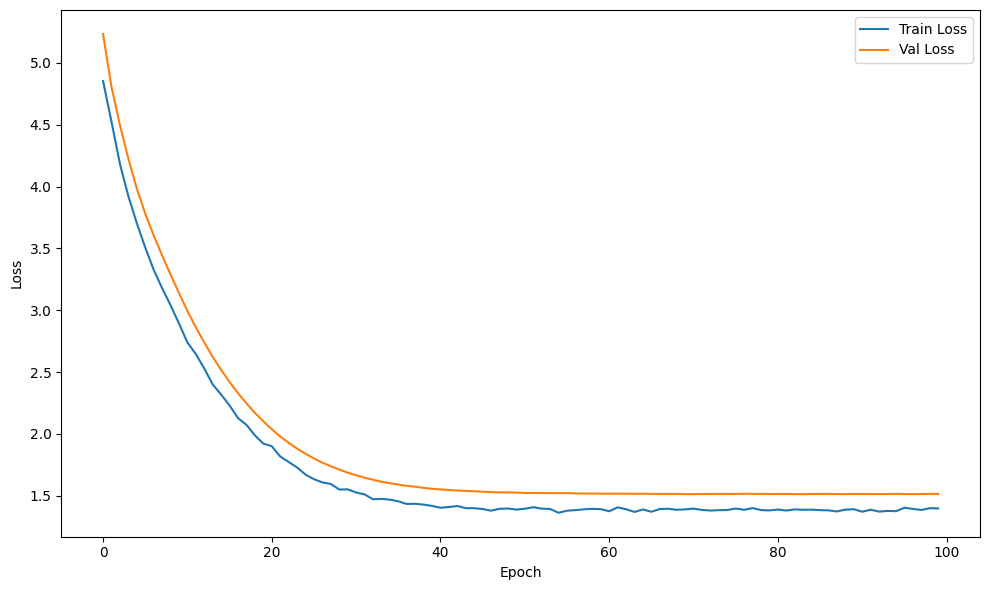

In [125]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
#plt.yscale('log')
plt.legend(); plt.tight_layout(); plt.show()


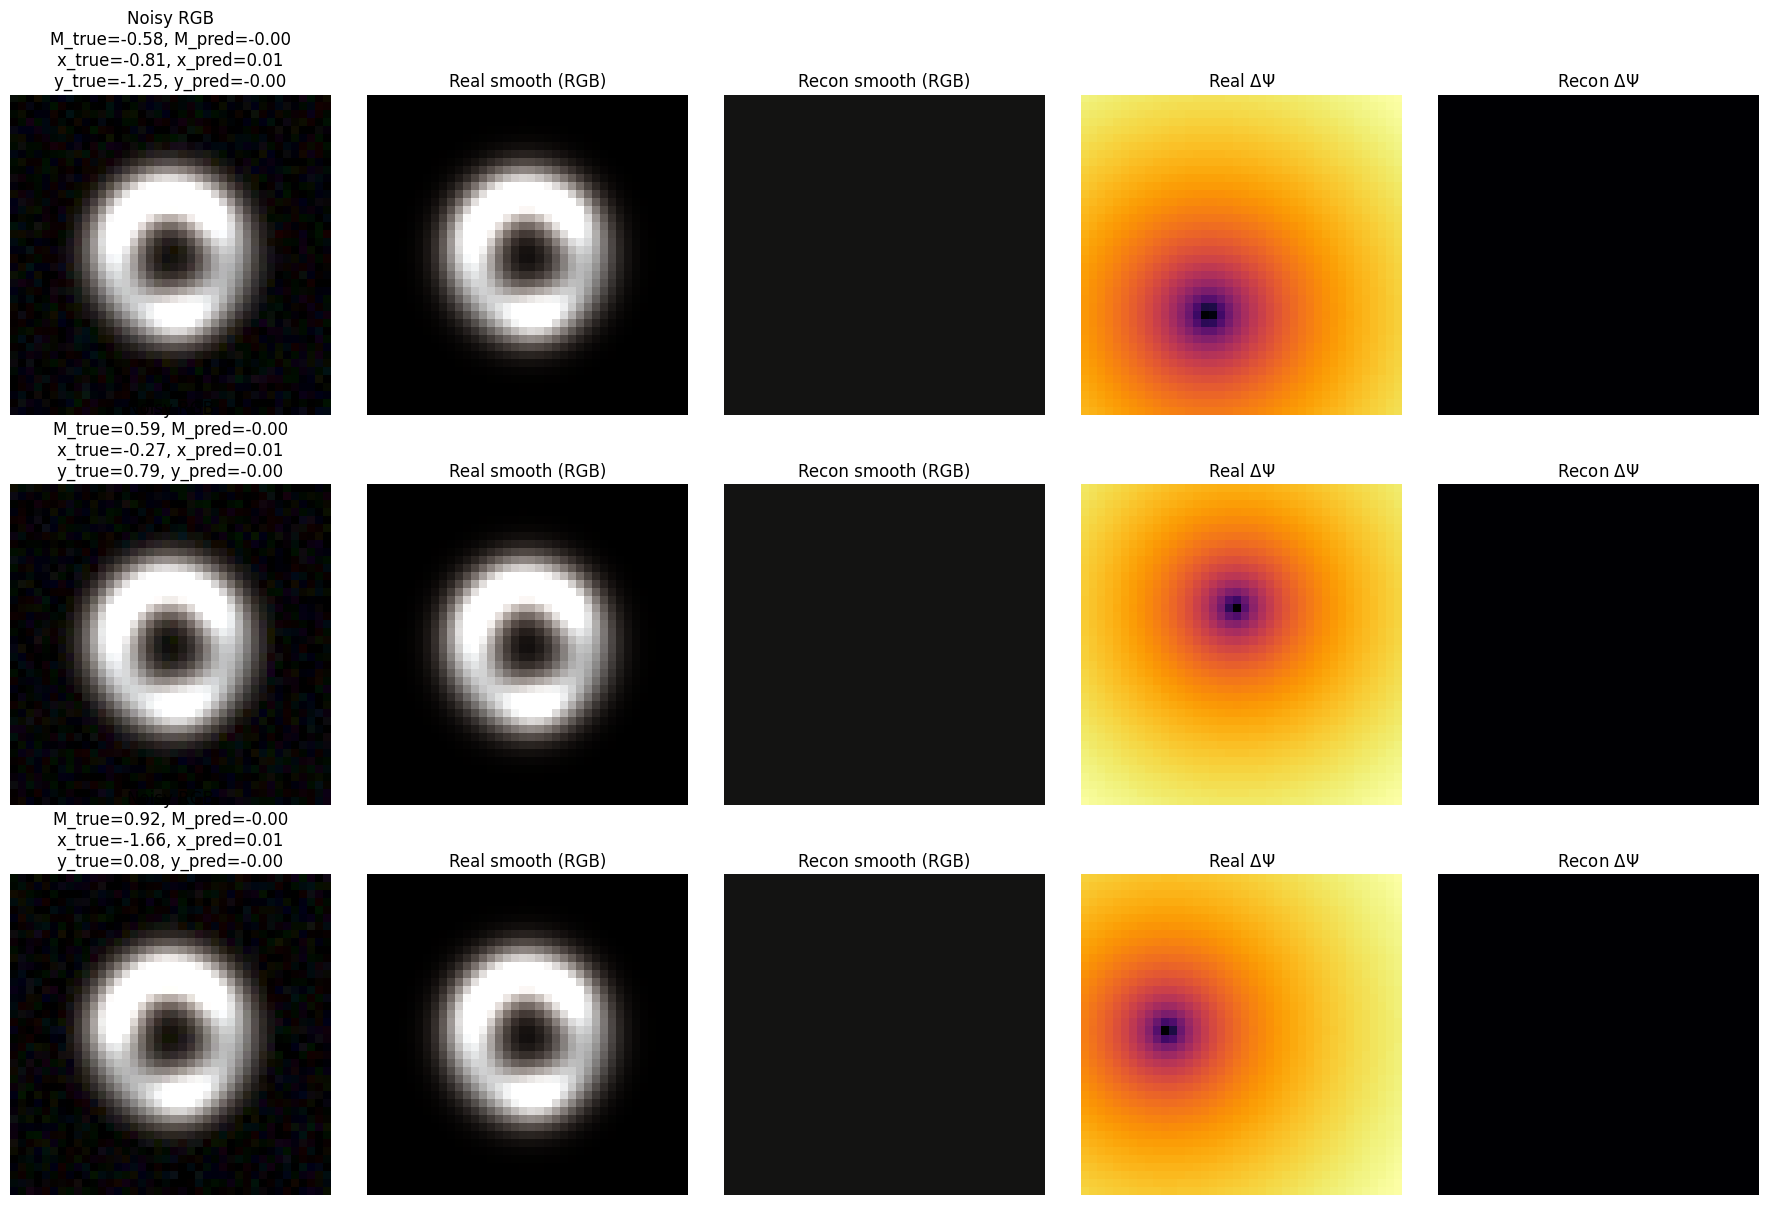

In [126]:
# === Visualización en TEST con manejo robusto de ejes y tamaños ===
model.eval()
with torch.no_grad():
    x, y_true_smooth, y_true_delta, mxy_true = next(iter(test_loader))
    x, y_true_smooth, y_true_delta, mxy_true = (
        x.to(device),
        y_true_smooth.to(device),
        y_true_delta.to(device),
        mxy_true.to(device),
    )
    y_pred_smooth, y_pred_delta, mu, logvar, mxy_pred = model(x)

# A CPU + NumPy
x_np         = x.detach().cpu().numpy()              # (N,3,H,W)
y_true_s_np  = y_true_smooth.detach().cpu().numpy()  # (N,3,H,W)
y_true_d_np  = y_true_delta.detach().cpu().numpy()   # (N,1,H,W)
y_pred_s_np  = y_pred_smooth.detach().cpu().numpy()  # (N,3,H,W)
y_pred_d_np  = y_pred_delta.detach().cpu().numpy()   # (N,1,H,W)
mxy_true_np  = mxy_true.detach().cpu().numpy()       # (N,3)
mxy_pred_np  = mxy_pred.detach().cpu().numpy()       # (N,3)

# Parámetros de muestreo
offset    = 0
max_rows  = 3
N         = x_np.shape[0]
n_samples = max(1, min(max_rows, N - offset))  # al menos 1 y no excede batch

# Crear figura
fig, axes = plt.subplots(n_samples, 5, figsize=(18, 4*n_samples))
# Forzar axes a shape (n_samples, 5)
if n_samples == 1:
    axes = np.array(axes).reshape(1, 5)

for i in range(n_samples):
    idx = i + offset

    # Valores de regresión
    m_true, x_true, y_true = mxy_true_np[idx]
    m_pred, x_pred, y_pred = mxy_pred_np[idx]

    # Col 0: Entrada ruidosa (RGB)
    ax = axes[i, 0]
    ax.imshow(np.clip(x_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title(
        f"Noisy RGB\n"
        f"M_true={m_true:.2f}, M_pred={m_pred:.2f}\n"
        f"x_true={x_true:.2f}, x_pred={x_pred:.2f}\n"
        f"y_true={y_true:.2f}, y_pred={y_pred:.2f}"
    )
    ax.axis('off')

    # Col 1: Smooth real (RGB)
    ax = axes[i, 1]
    ax.imshow(np.clip(y_true_s_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title("Real smooth (RGB)")
    ax.axis('off')

    # Col 2: Smooth recon (RGB)
    ax = axes[i, 2]
    ax.imshow(np.clip(y_pred_s_np[idx].transpose(1,2,0), 0, 1))
    ax.set_title("Recon smooth (RGB)")
    ax.axis('off')

    # Col 3: Δψ real (1 canal)
    ax = axes[i, 3]
    ax.imshow(y_true_d_np[idx, 0], origin='lower', cmap='inferno')
    ax.set_title(r"Real $\Delta\Psi$")
    ax.axis('off')

    # Col 4: Δψ recon (1 canal)
    ax = axes[i, 4]
    ax.imshow(y_pred_d_np[idx, 0], origin='lower', cmap='inferno')
    ax.set_title(r"Recon $\Delta\Psi$")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [127]:
print("X", X_train.min().item(), X_train.max().item())
print("Y1", Y1_train.min().item(), Y1_train.max().item())
print("Y2", Y2_train.min().item(), Y2_train.max().item())


X 0.0 1.0
Y1 1.5442640943774677e-08 1.0
Y2 -2.977926015853882 -0.5498024821281433


In [128]:
print("x:", x.min().item(), x.max().item())
print("s_pred:", s_pred.min().item(), s_pred.max().item())
print("y_s (GT):", y_s.min().item(), y_s.max().item())
print("d_pred:", d_pred.min().item(), d_pred.max().item())
print("y_d (GT):", y_d.min().item(), y_d.max().item())


x: 0.0 1.0
s_pred: 0.07442539185285568 0.07623382657766342
y_s (GT): 1.5442640943774677e-08 1.0
d_pred: -1.2041219472885132 -1.2041219472885132
y_d (GT): -2.9875998497009277 -0.5990505218505859


In [129]:
x, y_s, y_d, mxy = next(iter(train_loader))
print("x:", x.shape, x.min().item(), x.max().item())
print("y_s:", y_s.shape, y_s.min().item(), y_s.max().item())
print("y_d:", y_d.shape, y_d.min().item(), y_d.max().item())
print("mxy:", mxy.shape, mxy.mean(dim=0), mxy.std(dim=0))


x: torch.Size([64, 3, 40, 40]) 0.0 1.0
y_s: torch.Size([64, 3, 40, 40]) 1.5442640943774677e-08 1.0
y_d: torch.Size([64, 1, 40, 40]) -2.9777307510375977 -0.5498024821281433
mxy: torch.Size([64, 3]) tensor([ 0.1327, -0.0916, -0.0549]) tensor([1.0432, 1.0021, 1.0483])
